# House Prices: Advanced Regression

Kaggle educational [challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) for the BC Machine Learning working group practice.

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_log_error, make_scorer

% matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# this function is awesome! but doesn't render great on GitHub
# pandas_profiling.ProfileReport(df)

In [4]:
df.fillna(0, inplace=True)  # we'll get more sophisticated with missing values later...

In [5]:
y = df.SalePrice.values
X_df_raw = df[[col for col in df if col != 'SalePrice']]
X_df = pd.get_dummies(X_df_raw)
X = X_df.values

In [6]:
X_df.shape, X_df_raw.shape

((1460, 305), (1460, 80))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [8]:
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)
rf.score(X_val, y_val)  # this is R^2

0.89304353295504613

## Evaluation Metric: Root Mean Squared Log Error
RMSLE = $\sqrt{\frac{1}{N} \sum \left[ \ln(1 + y_{true}) - \ln(1 + y_{pred}) \right] ^2 }$

I found a few ways to apply this metric for scoring. Calculating it from the square root of the `mean_squared_log_error` function, or using the built in `neg_mean_squared_log_error` scikit-learn "scorer" in cross-validation, which still requires a sign change and the square root to be applied... I think the best way is the creation of the `rmsle_scorer` which I can reuse in different runs of cross-validation.

In [9]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))
    
rmsle_score = make_scorer(rmsle)

In [10]:
y_pred = rf.predict(X_val)
score = rmsle(y_val, y_pred)
score

0.14336691509934216

In [11]:
negMSLE_scores = cross_val_score(RandomForestRegressor(n_estimators=100), cv=5,
                                 X=X, y=y, n_jobs=-1, scoring='neg_mean_squared_log_error')

RMSLE_scores = np.sqrt(-1*negMSLE_scores)
RMSLE_scores.mean()

0.14678203044379712

In [12]:
RMSLE_scores = cross_val_score(RandomForestRegressor(n_estimators=100), cv=5,
                               X=X, y=y, n_jobs=-1, scoring=rmsle_score)
RMSLE_scores.mean()

0.14678203044379712

In [13]:
lm = Ridge()
lm.fit(X_train, y_train)
lm.score(X_val, y_val)  # R^2

0.88672082543357245

In [14]:
RMSLE_scores = cross_val_score(Ridge(), cv=5, X=X, y=y, n_jobs=-1, scoring=rmsle_score)
RMSLE_scores.mean()

0.16679059580800579

## Feature Importances & Weights

In [15]:
rf = RandomForestRegressor(n_estimators=1000)
_ = rf.fit(X, y)

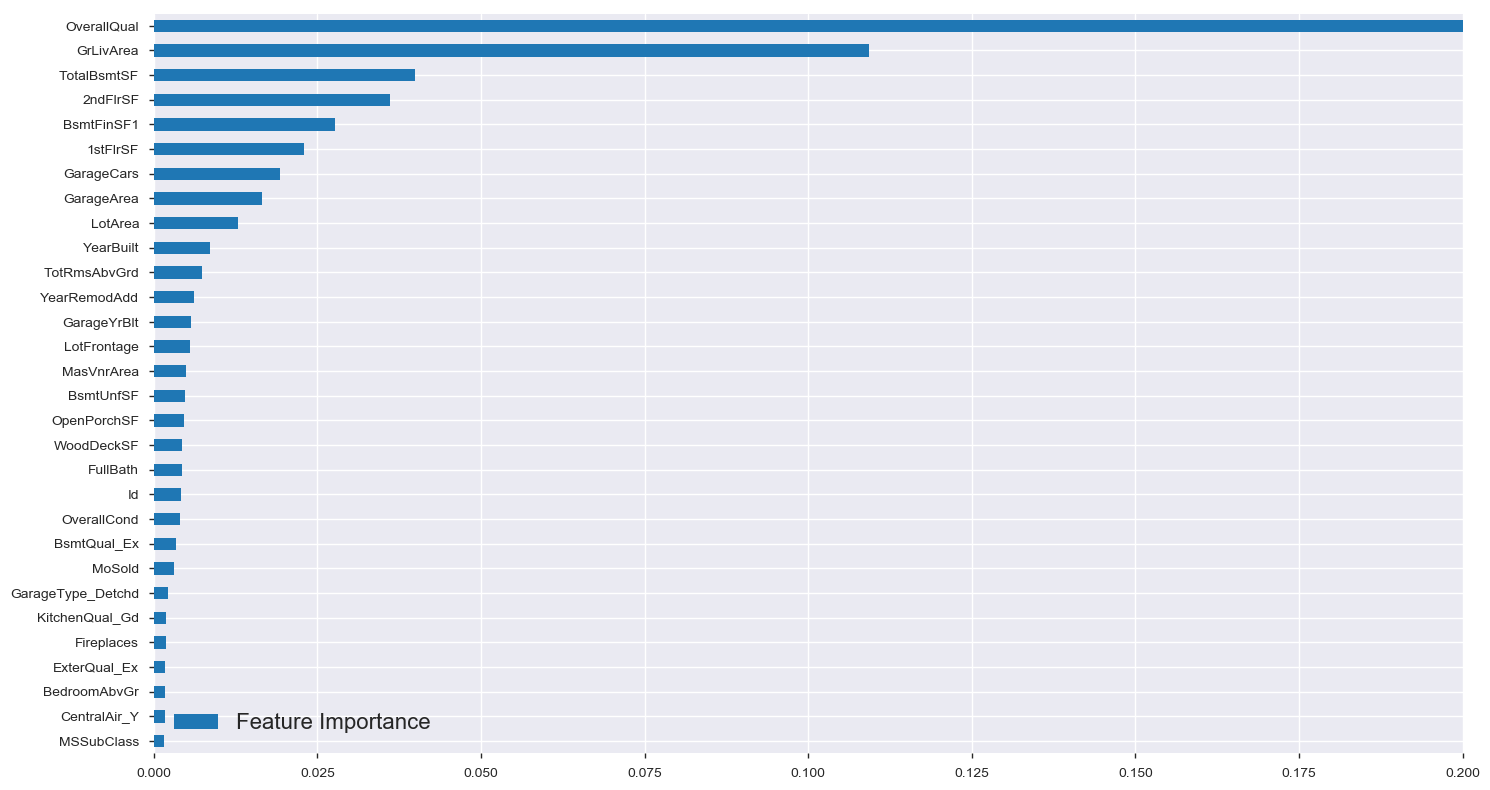

In [16]:
importance = pd.DataFrame({'Feature': X_df.columns.values, 'Feature Importance': rf.feature_importances_})
importance.index = importance.pop('Feature')
importance.sort_values(by='Feature Importance', ascending=True, inplace=True)
ax = importance.iloc[-30:].plot.barh(figsize=[15, 8])
ax.set_xlim([0, 0.2])
ax.set_ylabel('')
ax.legend(fontsize=16)
plt.tight_layout()

In [17]:
lm = Ridge()
_ = lm.fit(X, y)

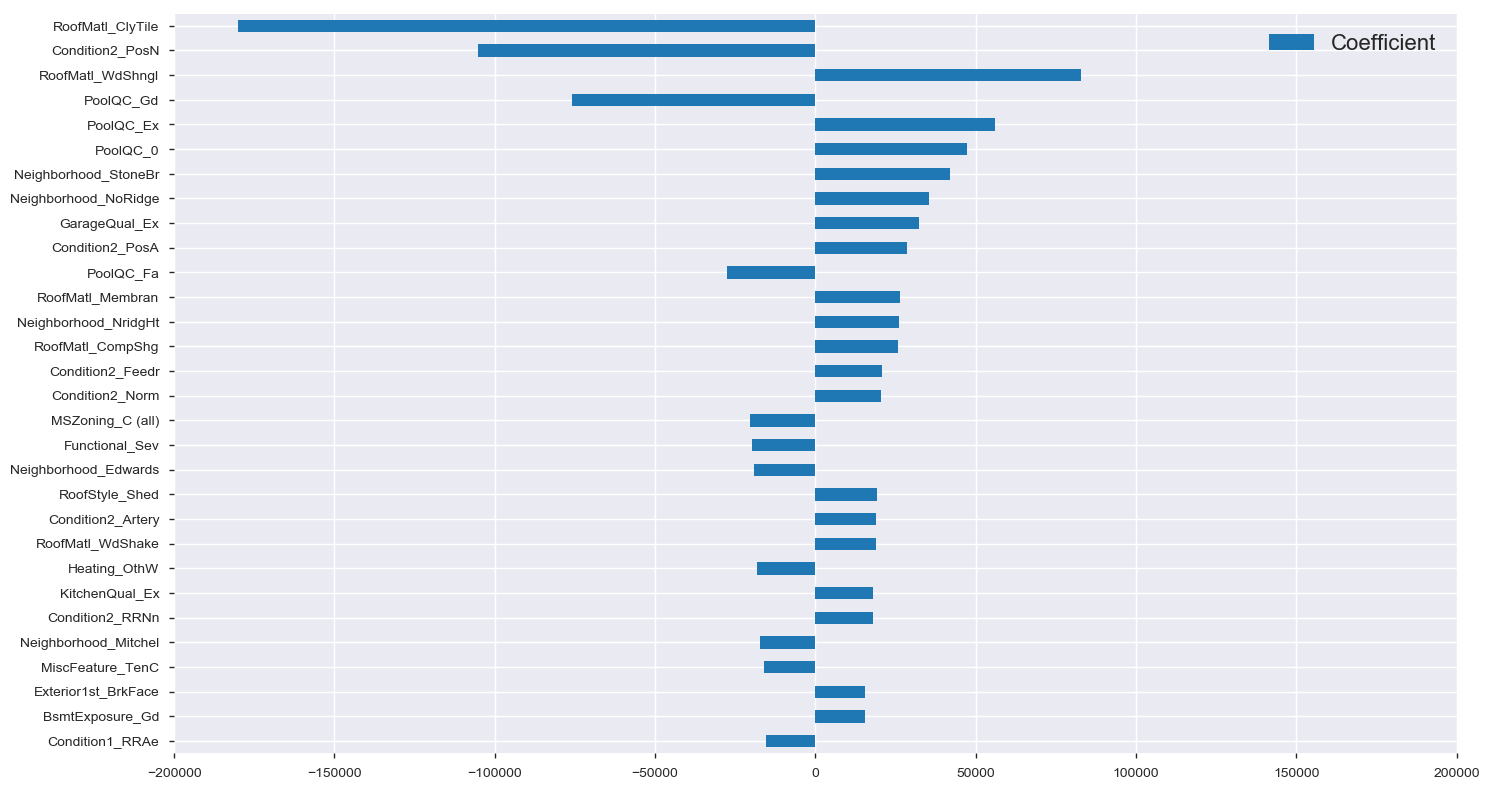

In [18]:
weight = pd.DataFrame({'Feature': X_df.columns.values, 'Coefficient': lm.coef_})
weight.index = weight.pop('Feature')
weight = weight.reindex(weight.Coefficient.abs().sort_values(ascending=True).index)
ax = weight.iloc[-30:].plot.barh(figsize=[15, 8])
ax.set_xlim([-2e5, 2e5])
ax.set_ylabel('')
ax.legend(fontsize=16)
plt.tight_layout()

## Feature Engineering

### Garage features...

In [19]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [20]:
df.GarageType.unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 0, 'Basment', '2Types'], dtype=object)

In [21]:
df[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']].sample(20)

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
310,Attchd,1993.0,Fin,TA,TA
583,Detchd,1988.0,Unf,Gd,TA
1340,Detchd,1974.0,Unf,TA,TA
1256,Attchd,1994.0,Fin,TA,TA
860,Detchd,1925.0,Unf,TA,TA
240,Attchd,2008.0,RFn,TA,TA
61,Detchd,1935.0,Unf,TA,TA
555,Detchd,1922.0,Unf,TA,TA
246,Detchd,1910.0,Unf,Po,Po
541,BuiltIn,2000.0,Fin,TA,TA


In [22]:
for null_column in df.columns[df.isnull().any()]:
    print('\n-------\n{}\n'.format(null_column))  #, df[null_column].dropna().mean())
    if df[null_column].dtype == 'float64':
        print(df[null_column].describe())
    else:
        pass